In [1]:
import pandas as pd
import os
import scipy
import numpy as np
from glob import glob

%load_ext rpy2.ipython

In [30]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(ggsegGlasser)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In [56]:
module_orders = pd.read_csv("../data/RH_cortex_module_orders_OSLOM30.csv")

In [52]:
OSLOM_results_path = "/Users/abry4213/github/OverlappingCommunityDetection_HCP/data/"

def parse_OSLOM_res(hemi_name): 

    OSLOM30_seed61_hemi_results = pd.read_csv(f"{OSLOM_results_path}/OSLOM30_robustness_{hemi_name}_cortex_communities.csv", header=None)

    OSLOM30_seed61_hemi_results_long = (OSLOM30_seed61_hemi_results
        .assign(Node_Index = lambda x: x.index + 1)
        .melt(id_vars=["Node_Index"], var_name="Module_Number", value_name="Member_Value")
        .assign(Member_Value = lambda x: np.where(x.Member_Value == 0, 0, 1))
        .query("Member_Value==1")
        .reset_index(drop=True)
        .drop(columns=["Member_Value"])
        )

    # return the long format dataframe
    return OSLOM30_seed61_hemi_results_long

# Load brain region labels
# The region to drop corresponds to node index 282
full_brain_region_lookup_table = pd.read_csv("../data/Glasser_360_and_subcortex_labels.csv")

# Fill in the gap for Node_Index so that it is continuous
full_brain_region_lookup_table = (full_brain_region_lookup_table
    .query("Node_Index != 282")
    .assign(Node_Index = lambda x: np.where(x.Node_Index > 282, x.Node_Index - 1, x.Node_Index))
    )

# Load OSLOM results per hemisphere
OSLOM30_seed61_RH_results = parse_OSLOM_res("RH").assign(Node_Index = lambda x: x.Node_Index + 190).merge(full_brain_region_lookup_table, on="Node_Index", how="left").query("Node_Index != 282")
OSLOM30_seed61_LH_results = parse_OSLOM_res("LH").merge(full_brain_region_lookup_table, on="Node_Index", how="left")
OSLOM30_seed61_full_results = parse_OSLOM_res("full").merge(full_brain_region_lookup_table, on="Node_Index", how="left").query("Node_Index != 282")

In [53]:
OSLOM30_seed61_RH_results.head()

,Node_Index,Module_Number,Region_Name,Base_Region,Hemisphere
0,204,0,R_RSC_ROI,RSC_ROI,Right
1,216,0,R_SFL_ROI,SFL_ROI,Right
2,217,0,R_PCV_ROI,PCV_ROI,Right
3,219,0,R_7Pm_ROI,7Pm_ROI,Right
4,226,0,R_5m_ROI,5m_ROI,Right


Joining with `by = join_by(Module_Number)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


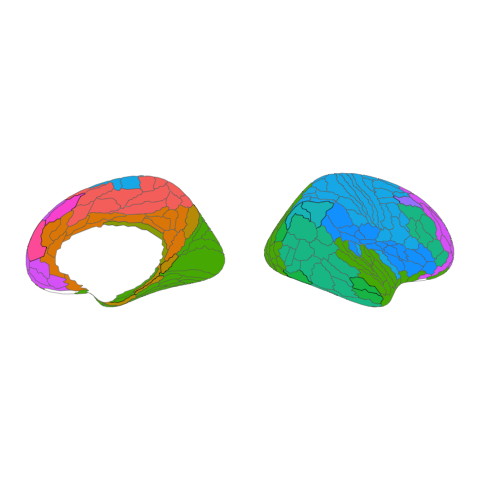

In [65]:
%%R -i OSLOM30_seed61_RH_results,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

# For Base_Region with multiple rows (ie multiple Module_Number) values, flatten and concatenate Module_Number values 
# Into one string separated by "_"
OSLOM30_seed61_RH_results_with_overlaps = OSLOM30_seed61_RH_results %>%
    group_by(Base_Region) %>%
    summarise(Module_Number = paste0(unique(Module_Number), collapse="_")) %>%
    ungroup() %>%
    mutate(Overlap = ifelse(str_detect(Module_Number, "_"), "Overlap", "No_Overlap")) %>%
    mutate(Hemisphere = "RH") %>% 
    left_join(module_orders) %>% 
    mutate(Base_Region = str_replace_all(Base_Region, "_ROI", ""))%>% 
    mutate(Base_Region = paste0("rh_R_", Base_Region)) %>%
    dplyr::rename("label" = "Base_Region") %>% 
    left_join(., glasser_lookup_table)

# Plot modules on cortical surface with Glasser parcellation
OSLOM30_seed61_RH_results_with_overlaps %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=Module_Number, color=Overlap),
             hemi = "right") +
  theme_void()  + 
  # scale_fill_discrete(na.translate = F) +
  labs(fill = "Community Detection Module") +
  scale_fill_manual(values=colormap, na.value='white') +
  scale_color_manual(values=c("Overlap" = "black", "No_Overlap" = "gray40")) +
  theme(legend.position="none")

Joining with `by = join_by(label)`


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  region side  label           geometry Module_Number
  <chr> <chr> <chr> <chr>  <chr> <chr>     <MULTIPOLYGON> <chr>        
1 <NA>  <NA>  <NA>  <NA>   <NA>  lh_L_10pp          EMPTY 2            
  Overlap    Hemisphere
  <chr>      <chr>     
1 No_Overlap LH         

R[write to console]: 2: Some data not merged. Check for spelling mistakes in:
         label Module_Number    Overlap Hemisphere
199 lh_L_10pp             2 No_Overlap         LH 



merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
Warning messages:
1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  region side  label           geometry Module_Number
  <chr> <chr> <chr> <chr>  <chr> <chr>     <MULTIPOLYGON> <chr>        
1 <NA>  <NA>  <NA>  <NA>   <NA>  lh_L_10pp          EMPTY 2            
  Overlap    Hemisphere
  <chr>      <chr>     
1 No_Overlap LH         
2: Some data not merged. Check for spelling mistakes in:
         label Module_Number    Overlap Hemisphere
199 lh_L_10pp             2 No_Overlap         LH 
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


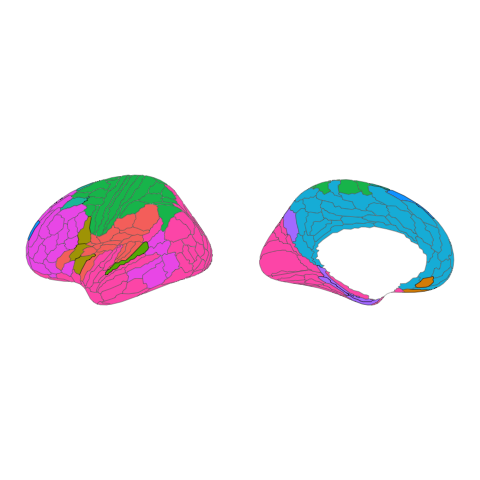

In [68]:
%%R -i OSLOM30_seed61_LH_results,module_orders

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

# For Base_Region with multiple rows (ie multiple Module_Number) values, flatten and concatenate Module_Number values 
# Into one string separated by "_"
OSLOM30_seed61_LH_results_with_overlaps = OSLOM30_seed61_LH_results %>%
    group_by(Base_Region) %>%
    summarise(Module_Number = paste0(unique(Module_Number), collapse="_")) %>%
    ungroup() %>%
    mutate(Overlap = ifelse(str_detect(Module_Number, "_"), "Overlap", "No_Overlap")) %>%
    mutate(Hemisphere = "LH") %>% 
    mutate(Base_Region = str_replace_all(Base_Region, "_ROI", ""))%>% 
    mutate(Base_Region = paste0("lh_L_", Base_Region)) %>%
    dplyr::rename("label" = "Base_Region") %>% 
    left_join(., glasser_lookup_table)

# Plot modules on cortical surface with Glasser parcellation
OSLOM30_seed61_LH_results_with_overlaps %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=Module_Number, color=Overlap),
             hemi = "left") +
  theme_void()  + 
  # scale_fill_discrete(na.translate = F) +
  labs(fill = "Community Detection Module") +
  scale_fill_discrete(na.value='white') +
  # scale_fill_manual(values=colormap, na.value='white') +
  scale_color_manual(values=c("Overlap" = "black", "No_Overlap" = "gray40")) +
  theme(legend.position="none")

merging atlas and data by 'label'


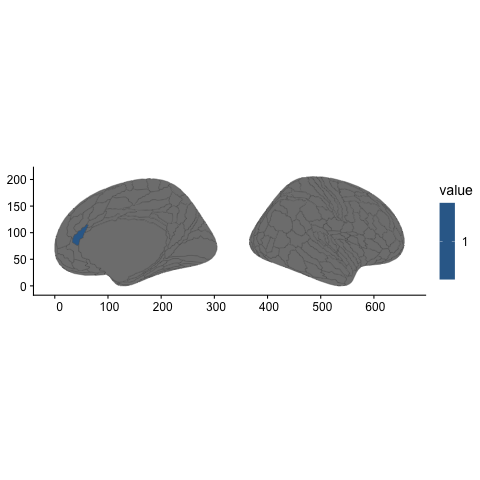

In [48]:
%%R 


# Merge modules + Glasser data
test_data <- data.frame(label = "rh_R_p24", value=1)

# Plot modules on cortical surface with Glasser parcellation
test_data %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=value),
             hemi = "right") 